# 1. Machine Learning

## 1.1 Data Preparation

In [75]:
import numpy as np
from pandas import read_csv

In [76]:
def parse_csv(filepath: str):
    data = read_csv(filepath)

    # targets = array of target values (last column)
    targets = data.values[:, -1].astype(float)

    # inputs = array of input values (all columns except last)
    inputs = data.values[:, :-1].astype(float)

    return np.array(inputs), np.array(targets)

In [77]:
inputs, targets = parse_csv('glass-dataset.csv')

In [78]:
# This is just to prove its working
print(inputs[:5]);

[[1.52101e+00 1.36400e+01 4.49000e+00 1.10000e+00 7.17800e+01 6.00000e-02
  8.75000e+00 0.00000e+00 0.00000e+00]
 [1.51761e+00 1.38900e+01 3.60000e+00 1.36000e+00 7.27300e+01 4.80000e-01
  7.83000e+00 0.00000e+00 0.00000e+00]
 [1.51618e+00 1.35300e+01 3.55000e+00 1.54000e+00 7.29900e+01 3.90000e-01
  7.78000e+00 0.00000e+00 0.00000e+00]
 [1.51766e+00 1.32100e+01 3.69000e+00 1.29000e+00 7.26100e+01 5.70000e-01
  8.22000e+00 0.00000e+00 0.00000e+00]
 [1.51742e+00 1.32700e+01 3.62000e+00 1.24000e+00 7.30800e+01 5.50000e-01
  8.07000e+00 0.00000e+00 0.00000e+00]]


## 1.2 Classification

In [79]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [80]:
def pca(inputs):
    pca = PCA(n_components=2)
    
    return pca.fit_transform(inputs)

In [81]:
compressed = pca(inputs)

In [82]:
def knn(inputs, targets, k: int):
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    classifier.fit(inputs, targets)
    
    return classifier.predict(inputs)

In [83]:
def how_good_is_k(inputs, targets, k: int):
    classifiedData = knn(inputs, targets, k)

    totalRight = 0
    totalEntries = len(targets)

    for i in range(totalEntries):
        if classifiedData[i] == targets[i]:
            totalRight += 1
    
    return totalRight / totalEntries

In [84]:
# Returns the most accurate k values' classified data
def classify_knn(inputs, targets):
    accuracies = []

    for k in range(1, 20):
        accuracies.append(how_good_is_k(inputs, targets, k))

    plt.figure()
    plt.plot(range(1, 20), accuracies)
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title("Accuracy of kNN with different k values")
    plt.show()
    
    return knn(inputs, targets, accuracies.index(max(accuracies)) + 1)

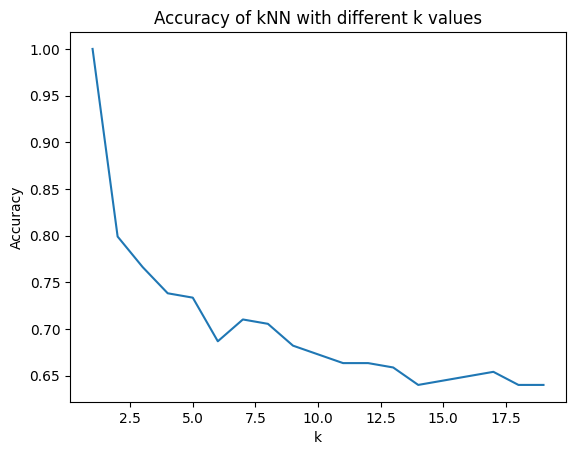

In [85]:
classifiedData = classify_knn(compressed, targets)

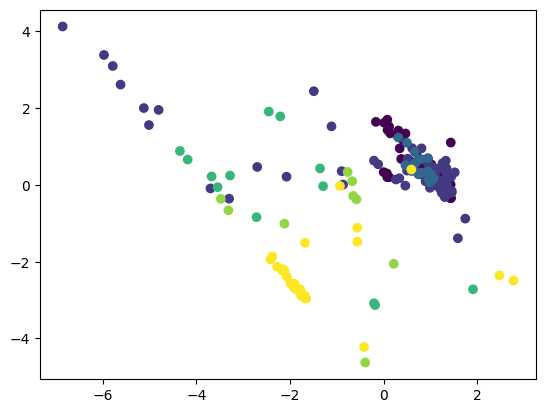

In [86]:
plt.figure()
plt.scatter(compressed[:, 0], compressed[:, 1], c=classifiedData)
plt.show()

In [87]:
# kernel can be "linear", "poly" or "rbf"
# degree can be 2 or 3
def svm(inputs, targets, kernel: str, degree: int):
    classifier = SVC(kernel=kernel, degree=degree)

    classifier.fit(inputs, targets)

    return classifier.predict(inputs)

In [88]:
def how_good_is_svm(inputs, targets, kernel, degree):
    classifiedData = svm(inputs, targets, kernel, degree)

    totalRight = 0
    totalEntries = len(targets)

    for i in range(totalEntries):
        if classifiedData[i] == targets[i]:
            totalRight += 1
    
    return totalRight / totalEntries

In [89]:
def classify_svm(inputs, targets):
    kernels = ["linear", "poly", "rbf"]
    degrees = [2, 3]
    accuracies = []

    for kernel in kernels:
        for degree in degrees:
            accuracies.append([kernel, degree, how_good_is_svm(inputs, targets, kernel, degree)])

    # this takes the 3rd item from the each item in the list and uses it as the key to get the highest acc.
    mostAccurate = max(accuracies, key=lambda x: x[2])

    return svm(inputs, targets, mostAccurate[0], mostAccurate[1])

In [90]:
classifiedData = classify_svm(inputs, targets)

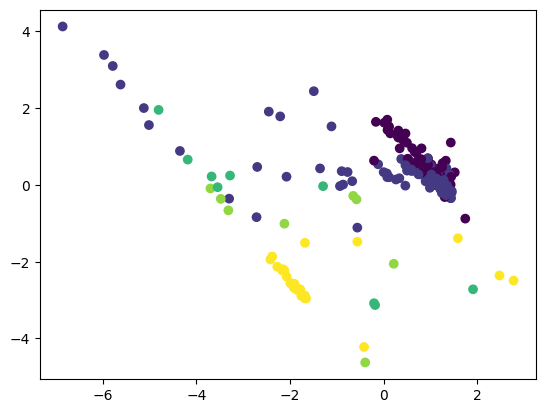

In [91]:
plt.figure()
plt.scatter(compressed[:, 0], compressed[:, 1], c=classifiedData)
plt.show()

## 1.3 Assessment of Classification

In [92]:
from sklearn.model_selection import cross_val_score

In [93]:
folds = 10;

In [94]:
def svm_cross_val(inputs, targets, kernel: str, degree: int):
    classifier = SVC(kernel=kernel, degree=degree)

    return cross_val_score(classifier, inputs, targets, cv=folds)

In [95]:
def knn_cross_val(inputs, targets, k: int):
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    return cross_val_score(classifier, inputs, targets, cv=folds)

In [96]:
knn_accuracies = knn_cross_val(compressed, targets, 1)
svm_accuracies = svm_cross_val(inputs, targets, "linear", 2)

/Users/bobbymannino/Code/comp2002-report/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/Users/bobbymannino/Code/comp2002-report/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


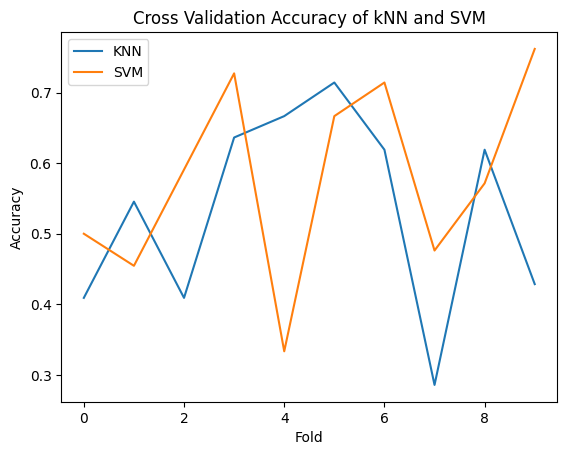

In [97]:
plt.figure()

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title("Cross Validation Accuracy of kNN and SVM")

plt.plot(range(folds), knn_accuracies, label="KNN")
plt.plot(range(folds), svm_accuracies, label="SVM")

plt.legend()
plt.show()

In [98]:
print("KNN Max", max(knn_accuracies))
print("SVM Max", max(svm_accuracies))

KNN Max 0.7142857142857143
SVM Max 0.7619047619047619


In [99]:
print("KNN Avg.", sum(knn_accuracies) / folds)
print("SVM Avg.", sum(svm_accuracies) / folds)

KNN Avg. 0.5333333333333334
SVM Avg. 0.5796536796536796


### Summary

After looking at the graph we can see that there is no clear winner, except maybe svm at fold 10, but if we had to pick an average winner it is not clear by the graph. If we look at the 2 blocks below the graph i have made a couple statements to see a numeric representation of the max and average of the scores. In both cases SVM comes out on top so i think to me it is clear which is more accurate, even if its only by 5%.

# 2. Optimization

## 2.1 Generation of Random Solutions

In [100]:
from math import sin, cos, exp, pi

In [101]:
def schaffer(x, y):
    top = sin(x**2 - y**2)**2 - 0.5;
    bottom = (1 + 0.001 * (x**2 + y**2))**2

    return 0.5 + (top / bottom);

In [102]:
def modified_schaffer(x, y):
    part1 = 20 * exp(-0.2 * (0.5 * (x**2 + y**2))**0.5);
    part2 = exp(0.5 * cos(2 * pi * x) + cos(2 * pi * y));

    return 20 - part1 - part2;

In [103]:
def easom(x, y):
    return cos(x) * cos(y) * exp(-((x - pi)**2 + (y - pi)**2));

In [104]:
def plot500RandomValues(fn, label: str):
    x = np.random.uniform(-5, 5, 500);
    y = np.random.uniform(-5, 5, 500);

    z = []

    for i in range(len(x)):
        z.append(fn(x[i], y[i]));

    plt.figure();
    plt.scatter(x, y, c=z);
    plt.colorbar();
    plt.title(label);
    plt.show();

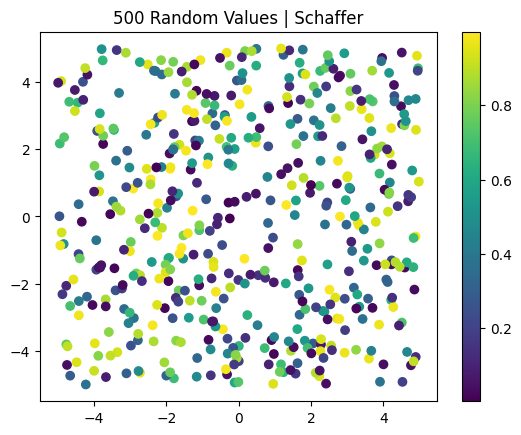

In [105]:
plot500RandomValues(schaffer, '500 Random Values | Schaffer');

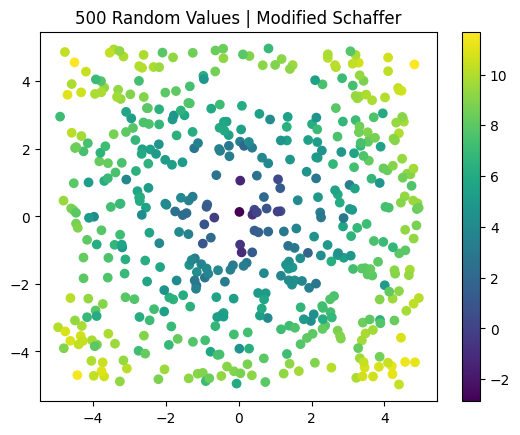

In [106]:
plot500RandomValues(modified_schaffer, '500 Random Values | Modified Schaffer');

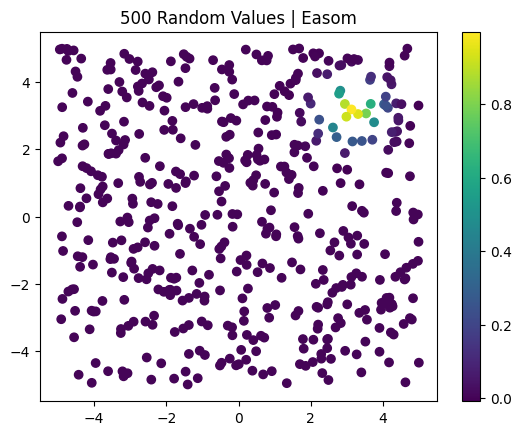

In [107]:
plot500RandomValues(easom, '500 Random Values | Easom');

## 2.2 Algorithm Implementation